<a href="https://colab.research.google.com/github/DanielJacksonEdu/GEOG5302M-Programming-for-Data-Science/blob/main/Lab8/Lab8_Spatial_Part2(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 9
## Spatial Analysis: Part 2
## Spatial Correlations and Modelling Techniques

## Setting Up

Welcome to Part 2 of our Spatial Analysis topic. In this lab, we'll coninue straight on from last session, by getting stuck into our spatial modelling.

We'll start with a quick recap from last week to refresh your memory, before we look at spatial autocorrelation and two of the most common spatial regression techniques: geographically weighted regression, and multilevel modelling.

As this session carries on directly from Lab 8, we can quickly get started by loading in the shapefile we saved at the end of last week. If you prefer, you can download my version from Minerva.

In [1]:
pip install palettable descartes pysal matplotlib_scalebar geopandas contextily

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.4/347.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.

In [2]:
import pandas as pd
import numba
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as pltt
import descartes
from pysal.viz import mapclassify
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
#import contextily as cx
%matplotlib inline
from pysal.lib import weights
from pysal.lib import io
import contextily as cx

Start by loading in the Leeds buses data from last week:

In [4]:
Leeds_bus = gpd.read_file('LeedsBuses.shp')

<br><br><br>

## Spatial Recap
To remind ourselves of the data and methods we've just so far, we'll have a quick look at the variables.

In [5]:
#view the top of the data
Leeds_bus.head()

,OBJECTID,MSOA11CD,MSOA11NM,LONG,LAT,Location,outline,Area,GP_dist,PO_dist,School_dis,Shop_dist,Population,Bus_Stops,geometry
0,1716,E02002337,Leeds 008,-1.752,53.880,North,1,1.488289e+07,1.053273,1.268455,0.796909,0.727182,7388,17,"POLYGON ((418310.512 440995.504, 418283.825 44..."
1,1718,E02002339,Leeds 010,-1.692,53.868,North,1,1.413270e+06,0.928857,1.253929,0.712857,0.536571,5351,25,"POLYGON ((420442.406 442436.687, 420443.313 44..."
2,1719,E02002340,Leeds 011,-1.678,53.868,North,1,2.175963e+06,0.888700,1.152800,0.804300,0.477500,5554,20,"POLYGON ((421248.688 442315.812, 421284.072 44..."
3,2527,E02002336,Leeds 007,-1.639,53.883,North,1,2.879803e+07,1.211063,1.528187,0.868750,0.805938,6596,68,"POLYGON ((422959.334 445561.228, 422975.661 44..."
4,1717,E02002338,Leeds 009,-1.709,53.870,North,1,2.126169e+06,1.106091,1.255364,0.705091,0.682727,6817,27,"POLYGON ((419597.106 440500.097, 419562.826 44..."


<Axes: >

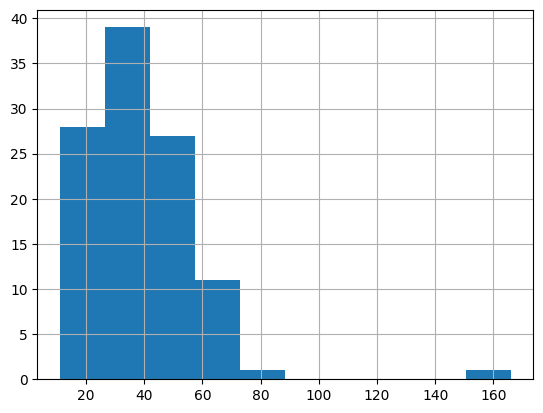

In [6]:
#create a histogram of the number of bus stops in Leeds
Leeds_bus['Bus_Stops'].hist()

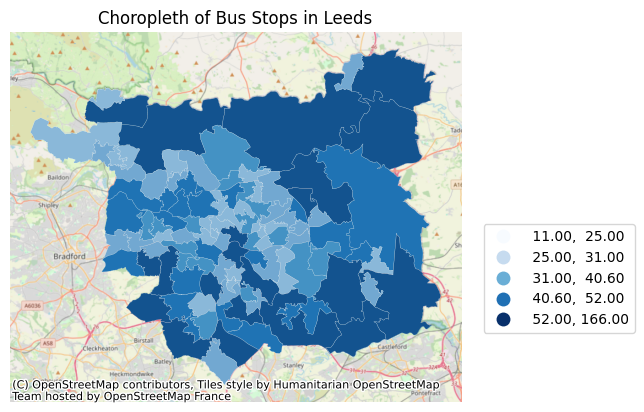

In [7]:
#create a Choropleth of the number of bus stops in each MSOA, using a sequential colour scheme
#and add a background map
fig, ax = plt.subplots(1) #create the figure
Leeds_bus.plot(ax = ax,column = 'Bus_Stops', scheme = 'quantiles', k = 5,legend = True, cmap='Blues')
#add the plot, colouring by number of bus stops, divided into 5 quantiles
plt.title('Choropleth of Bus Stops in Leeds') #add a title
leg = ax.get_legend() #add the legend
leg.set_bbox_to_anchor((1.4,0.5)) #set the position of the legend- you can change these numbers to see how it works
ax.set_axis_off() #remove the axes

Leeds_bus.plot(ax = ax, edgecolor = 'white', linewidth = 0.2, alpha = 0.5)
cx.add_basemap(ax, crs = 'EPSG:27700') #add the basemap and tell it which CRS to use- we want the same as our data
ax.set_axis_off()

plt.show() #show the plot



<br><br><br>
## Spatial Lag

First, we need to recalculate the queen weights we used last week.

In [8]:
#calculate the queen weights based on the MSOA id, like we did last week
w_queen = weights.Queen.from_dataframe(Leeds_bus, ids = 'MSOA11CD') #based on the id

Now create a histogram of the number of neighbours. Remember, you'll need to convert the weights to cardinalities first.

In [9]:
queen_card = pd.Series(w_queen.cardinalities)

<Axes: >

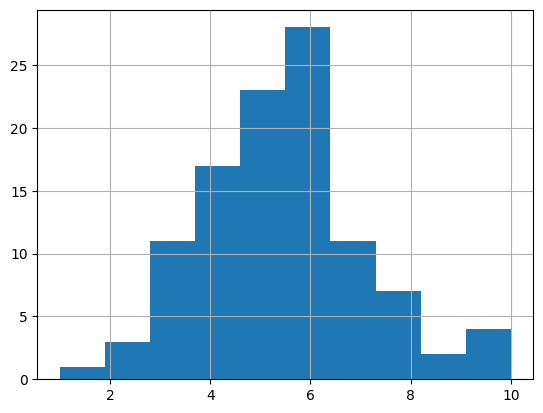

In [10]:
queen_card.hist()

Now moving on to spatial analysis itself, we start by calculating the spatial lag, which is the product of the spatial weights matrix and the variable of interest- in other words, the neighbourhood average of our variable.  We'll focus on number of bus stops for now.
We standardise the weights, to give us a proportion between 0 and 1. We then apply these weights to the neighbours of each MSOA in turn, and use this to calculate the weighted-average number of bus stops in each MSOA- this is the spatial lag.

In [11]:
w_queen.transform = 'R' #standardise across rows
w_queen_score = weights.lag_spatial(w_queen, Leeds_bus['Bus_Stops']) #compute spatial lag of the number of bus stops

We then add this as a column to our `Leeds_bus` data frame, and call it `W_Q_Score`.

In [12]:
#add to the data table as a new column
Leeds_bus['W_Q_Score'] = w_queen_score

Now we can use this to create a Moran Plot, which plots the variable values against their spatial lag.

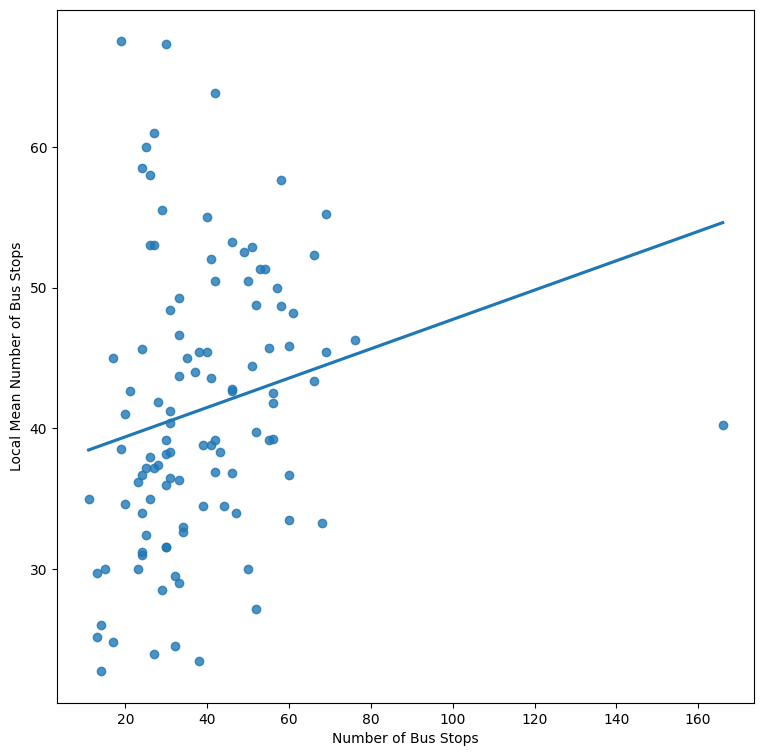

In [13]:
fig, ax = plt.subplots(1, figsize = (9,9)) #create plot
sns.regplot(x = 'Bus_Stops', y = 'W_Q_Score', data = Leeds_bus, ci =None) #add the x and y variables to a regression plot
plt.xlabel('Number of Bus Stops')
plt.ylabel('Local Mean Number of Bus Stops')
plt.show() #plot


We often standardise the variable to make it easier to spot outliers, by subtracting the mean and dividing by the standard deviation.

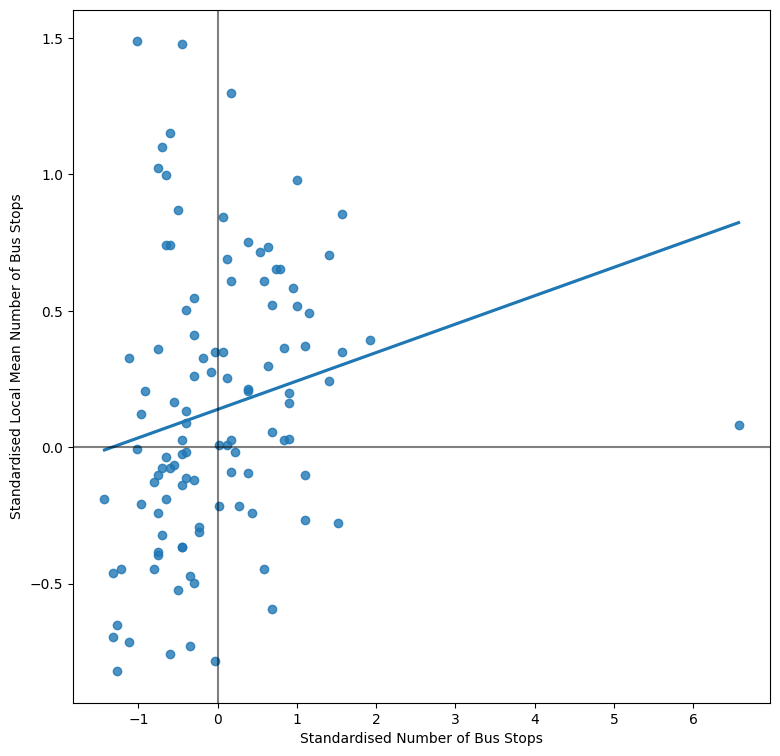

In [14]:
std_Bus = (Leeds_bus['Bus_Stops'] - Leeds_bus['Bus_Stops'].mean()) / Leeds_bus['Bus_Stops'].std() # calculate standardised scores
std_w_Bus =pd.Series(weights.lag_spatial(w_queen, std_Bus), index = std_Bus.index) #compute spatial lag

fig, ax = plt.subplots(1, figsize=(9,9))
sns.regplot(x = std_Bus, y = std_w_Bus, ci=None)
plt.xlabel('Standardised Number of Bus Stops')
plt.ylabel('Standardised Local Mean Number of Bus Stops')
plt.axvline(0, c='k', alpha = 0.5) #add vertical 0 line
plt.axhline(0, c='k', alpha = 0.5)
plt.show()

Can you spot any outliers here? Thinking about the geography of Leeds (or any big city), and the distribution of bus stops, why do you think this might be?

To prevent our main outlier skewing the data, what we will do is set it to the second highest value, to bring it in line with the other values.

What is the value of the main outlier?

In [15]:
#find the maximum value for the number of bus stops
Leeds_bus.Bus_Stops.max()

166

In [16]:
bus_sort = Leeds_bus.Bus_Stops.tolist() #create a list of the bus stop numbers
bus_sort.remove(max(bus_sort)) #remove maximum value
#set the maximum value in our spatial data frame and set it to the new max (second ma)
Leeds_bus['Bus_Stops_Clean'] = Leeds_bus.Bus_Stops #create a new column
Leeds_bus.loc[Leeds_bus['Bus_Stops']>100, 'Bus_Stops_Clean'] = max(bus_sort)
#if the number is greater than 100 in the original variable, set it equal to the maximum value of our cleaned variable

In [17]:
#check the new maximum value
Leeds_bus.Bus_Stops_Clean.max()

76

Now re-create the above plot of standardised spatial lag to see how it looks with the outlier amended:

In [18]:
#recreate the standardised spatial lag plot using the cleaned number of Bus Stops

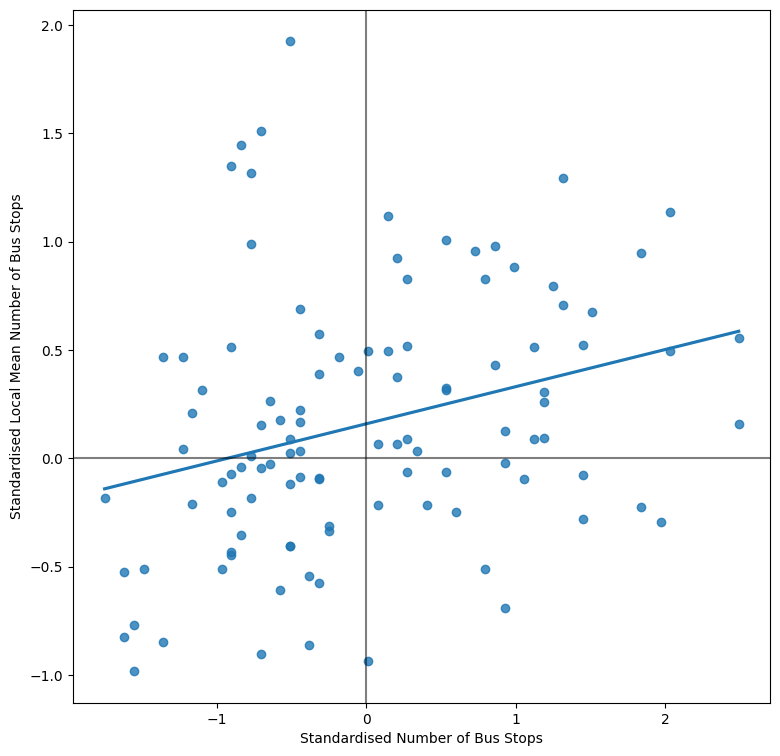

In [19]:
std_Bus = (Leeds_bus['Bus_Stops_Clean'] - Leeds_bus['Bus_Stops_Clean'].mean()) / Leeds_bus['Bus_Stops_Clean'].std() # calculate standardised scores
std_w_Bus =pd.Series(weights.lag_spatial(w_queen, std_Bus), index = std_Bus.index) #compute spatial lag

fig, ax = plt.subplots(1, figsize=(9,9))
sns.regplot(x = std_Bus, y = std_w_Bus, ci=None)
plt.xlabel('Standardised Number of Bus Stops')
plt.ylabel('Standardised Local Mean Number of Bus Stops')
plt.axvline(0, c='k', alpha = 0.5) #add vertical 0 line
plt.axhline(0, c='k', alpha = 0.5)
plt.show()

What does this plot tell us? Well, just as with linear regression, it gives us an insight into the relationship between the _x_ and _y_ variables. In this case, that's the number of bus stops, and the neighbour-weighted average number of bus stops. A positive association would imply that the _x_ value is similar to its neighbours, while a negative association implies that the _x_ value tends to be different to its neighbours. Both associations imply there is variation across space, while if we can see no association, this suggests there is no spatial relationship.  So what does this mean in terms of our bus stops? Note down your thoughts below!

In [20]:
#your thoughts here!
# This plot tells us that the number of bus stops in an area is similar to its spatial neighbours

## __Plotting Spatial Averages__
We can also plot the spatial lag on a map, which will show us how the average of our variable of interest varies across space. This is a really useful way of exploring our key variables before we add them to a model

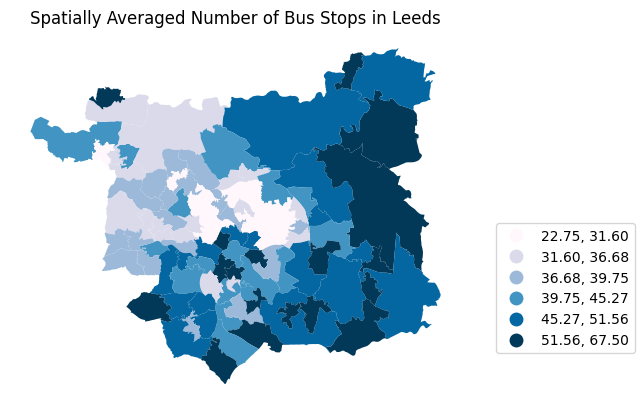

In [21]:
fig, ax = plt.subplots(1)
Leeds_bus.plot(ax = ax,column = 'W_Q_Score', cmap = 'PuBu', scheme = 'quantiles', k = 6,legend = True)
plt.title('Spatially Averaged Number of Bus Stops in Leeds') #add a title
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4,0.5))
ax.set_axis_off()
plt.show()

We could also plot this alongside the number in each LSOA, for comparison:

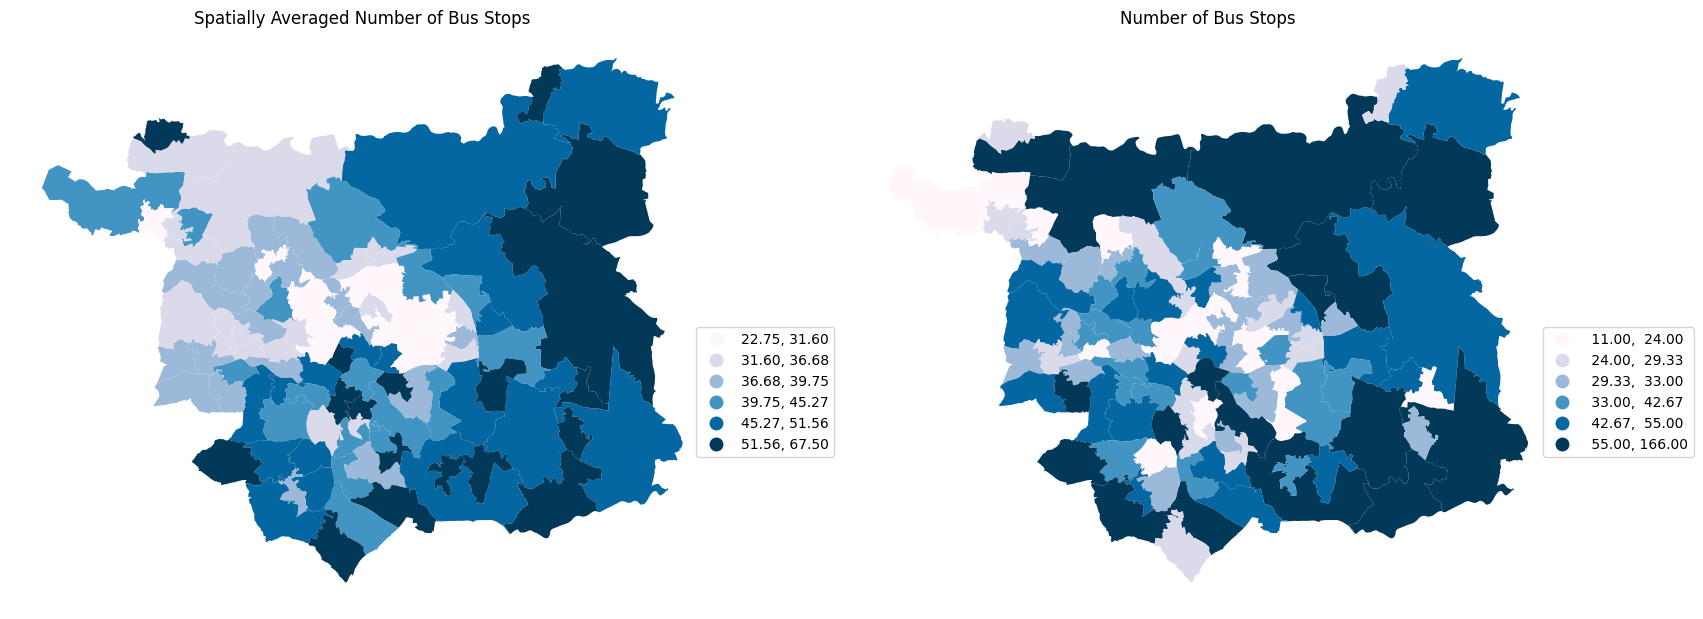

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
Leeds_bus.plot(ax = ax1,column = 'W_Q_Score', cmap = 'PuBu', scheme = 'quantiles', k = 6,legend = True)
Leeds_bus.plot(ax = ax2,column = 'Bus_Stops', cmap = 'PuBu', scheme = 'quantiles', k = 6,legend = True)
ax1.set_axis_off()
ax2.set_axis_off()
leg1 = ax1.get_legend()
leg1.set_bbox_to_anchor((1.18,0.5))
leg2 = ax2.get_legend()
leg2.set_bbox_to_anchor((1.2,0.5))
ax1.title.set_text('Spatially Averaged Number of Bus Stops')
ax2.title.set_text('Number of Bus Stops')
plt.show()

<br><br><br>
## Moran's _I_
We can now examine spatial lag more statistically, in terms of the Moran's _I_ value, which quantifies the global (ie whole-sample) spatial autocorrelation within the data. As we learnt in the lecture, this value indicates the relative extent, and significance, of spatial clustering within the data. It does this by calculating the correlation between each value and its (weighted) neighbours.
Again, we'll focus on the number of bus stops per MSOA. To continue, start by importing the Moran's _I_  modules.

In [23]:
from pysal.explore import esda
from pysal.viz import splot
#add set the position of the legend
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
#add patches for custom legends
import matplotlib.patches as mpatches

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


We can now calculate our Moran's _I_ value easily- we just need to specify the data we're using, and which weights.

In [24]:
mi = esda.Moran(Leeds_bus['Bus_Stops_Clean'], w_queen) #we'll use our queen weights

We then examine the value and significance of `mi`. First check the I value, by `print`ing the `.I` command on `mi`:

In [25]:
#print the I value
print(mi.I)

0.17151754414555262


And we check the statistical significance, using the `p_sim` command:

In [26]:
#print the p values
print(mi.p_sim)

0.004


Remembering that _I_ values vary from -1 (different values cluster) to 0 (no clustering) to +1 (similar values cluster), what do these values tell us about the direction, strength, and significance of clustering in the number of bus stops?

In [27]:
#comment on the Moran's I here
# The I value indicates that there is weak clustering of similar bus stop numbers in space, and that this
# this result is statistically significant at the 0.05 level as p < 0.05.

We can also create a Moran scatterplot, which should look exactly the same as our plots above!
(Sorry for making you do it the long way first, but this should help you understand each step and how the Moran plot works!)

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.17)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

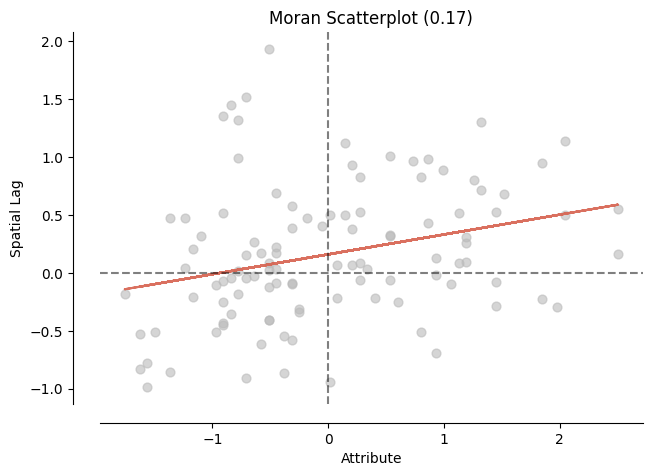

In [28]:
moran_scatterplot(mi) #create the scatterplot

<br><br><br>
## LISA Clusters

Now we can drill down to a more local level, and examine how our Moran's _I_ values vary across space, and therefore how the different clusters of higher and lower values vary in Leeds. Essentially, this method calculates a Moran's _I_ value for each polygon in our data. If we average these values, it should give us the global Moran's _I_ value.

We calculate our _LISA_ values (Local Indices of Spatial Autocorrelation) in the same way as our global autocorrelation (Moran's _I_), specifying the data (again the bus stops) and the weights (again we'll stick with the queen neighbours). Edit the code below to calculate the LISA clusters:

In [29]:
#calculate LISA clusters
#lisa = esda.Moran_Local(#data, #weights)
lisa = esda.Moran_Local(Leeds_bus['Bus_Stops_Clean'], w_queen)

We then use similar commands as with our Moran's _I_ to calculate the significance and values of LISA. In this case, we'll use this to create a LISA Cluster plot, like we saw in the lecture:

(<Figure size 640x480 with 1 Axes>, <Axes: >)

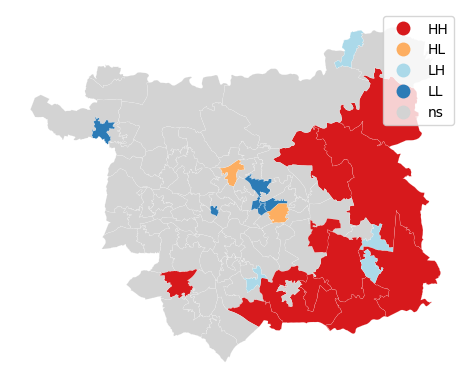

In [30]:
lisa_cluster(lisa, Leeds_bus)

What does this map tell us about the clusters of higher and lower numbers of bus stops? Remember what we covered in the lecture:

High-high (dark red): high values surrounded by high values <br>
High-low (light red): high values surrounded by low values <br>
Low-low (dark blue): low values surrounded by low values <br>
Low-high (light blue): low values surrounded by high values <br>

Comment on this below:

In [ ]:
#your comments

High values of bus stops surrounded by high values are disproportionately in East and South Leeds. The clusters are mostly in East Leeds.

We can also create the plot manually, to have more control over colours and features, etc:

In [31]:
Leeds_bus['Sig'] = lisa.p_sim <0.05 #calculate a variable to show which are significant at the 95% level
Leeds_bus['Quad'] = lisa.q #calculate a variable indicating the respective quadrant

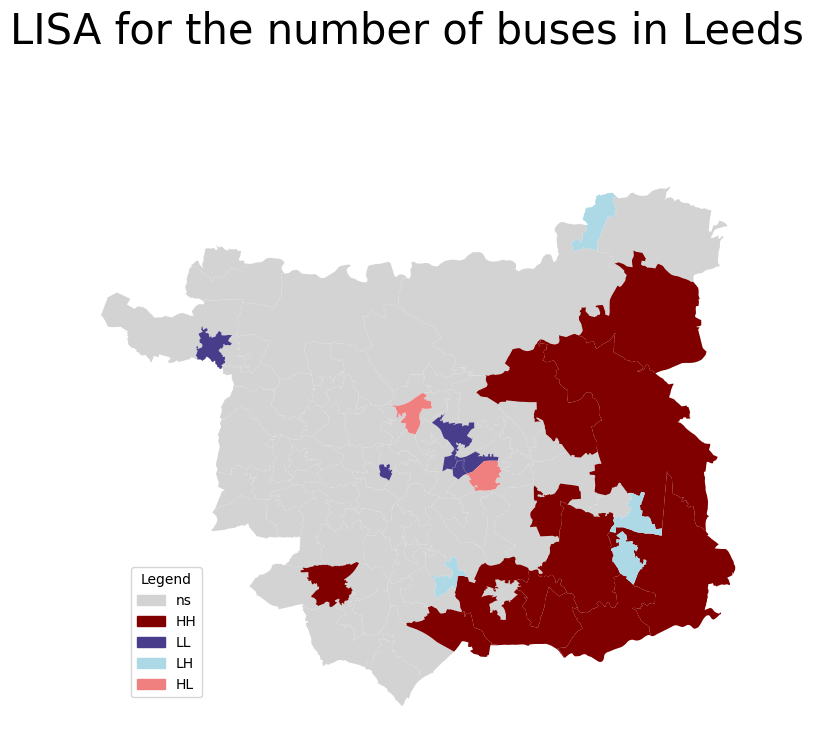

In [32]:
#create a figure
fig, ax = plt.subplots(1, figsize = (9,9))
#plot insignificant clusters
ns = Leeds_bus.loc[Leeds_bus['Sig'] == False, 'geometry']
ns.plot(ax = ax, color = 'lightGrey')
#plot HH clusters
hh = Leeds_bus.loc[(Leeds_bus['Quad']==1) & (Leeds_bus['Sig'] == True), 'geometry']
hh.plot(ax=ax, color = 'Maroon')
#plot lH clusters
ll = Leeds_bus.loc[(Leeds_bus['Quad']==3) & (Leeds_bus['Sig'] == True), 'geometry']
ll.plot(ax=ax, color = 'DarkSlateBlue')
#plot HH clusters
lh = Leeds_bus.loc[(Leeds_bus['Quad']==2) & (Leeds_bus['Sig'] == True), 'geometry']
lh.plot(ax=ax, color = 'LightBlue')
#plot HH clusters
hl = Leeds_bus.loc[(Leeds_bus['Quad']==4) & (Leeds_bus['Sig'] == True), 'geometry']
hl.plot(ax=ax, color = 'LightCoral')
#add titles
fig.suptitle('LISA for the number of buses in Leeds', size = 30)
fig.set_facecolor('1')
ax.set_axis_off()

#now add a custom legend, start by creating a coloured and labelled item for each component of the plot
ns_lab = mpatches.Patch(color='lightGrey', label='ns')
hh_lab = mpatches.Patch(color='Maroon', label='HH')
ll_lab = mpatches.Patch(color='DarkSlateBlue', label='LL')
lh_lab = mpatches.Patch(color='Lightblue', label='LH')
hl_lab = mpatches.Patch(color='LightCoral', label='HL')


#then plot the legend
leg = plt.legend(handles=[ns_lab, hh_lab,ll_lab,lh_lab,hl_lab], title="Legend")
#and move the legend to a convenient location
leg.set_bbox_to_anchor((0.2,0.3))


plt.show()

Now we've found some significant spatial autocorrelation in the data, what does this mean? This means that we need to take account of this spatial variation in our data, so it's time to use some spatial modelling techniques.

<br><br><br>

## Geographically Weighted Regression

To work towards our geographical regressions, we start with linear models (yay for something familiar) and then calculate residuals and autocorrelations, before building our GWR.

In [33]:
import statsmodels.api as sm #add statsmodels
from statsmodels.sandbox.regression.predstd import wls_prediction_std #allow us to predict

We create a subset of `Bus_Stops_Clean`, `Population` and the four access distance measures.

__Hint:__ Lab 4 resources may be a really helpful refresher here!

__Hint:__ When we save data, like we did last week, Python puts a limit on the length of variable names, so some of these may look slightly different to the original data we loaded in. Make sure to check the names of the variables before you add them to the subset.

In [34]:
#create your subset
Leeds_sub = Leeds_bus[['Bus_Stops_Clean', 'Population', 'GP_dist', 'PO_dist', 'School_dis', 'Shop_dist']]

And plot a scatter matrix to examine the visual correlations within the subset:

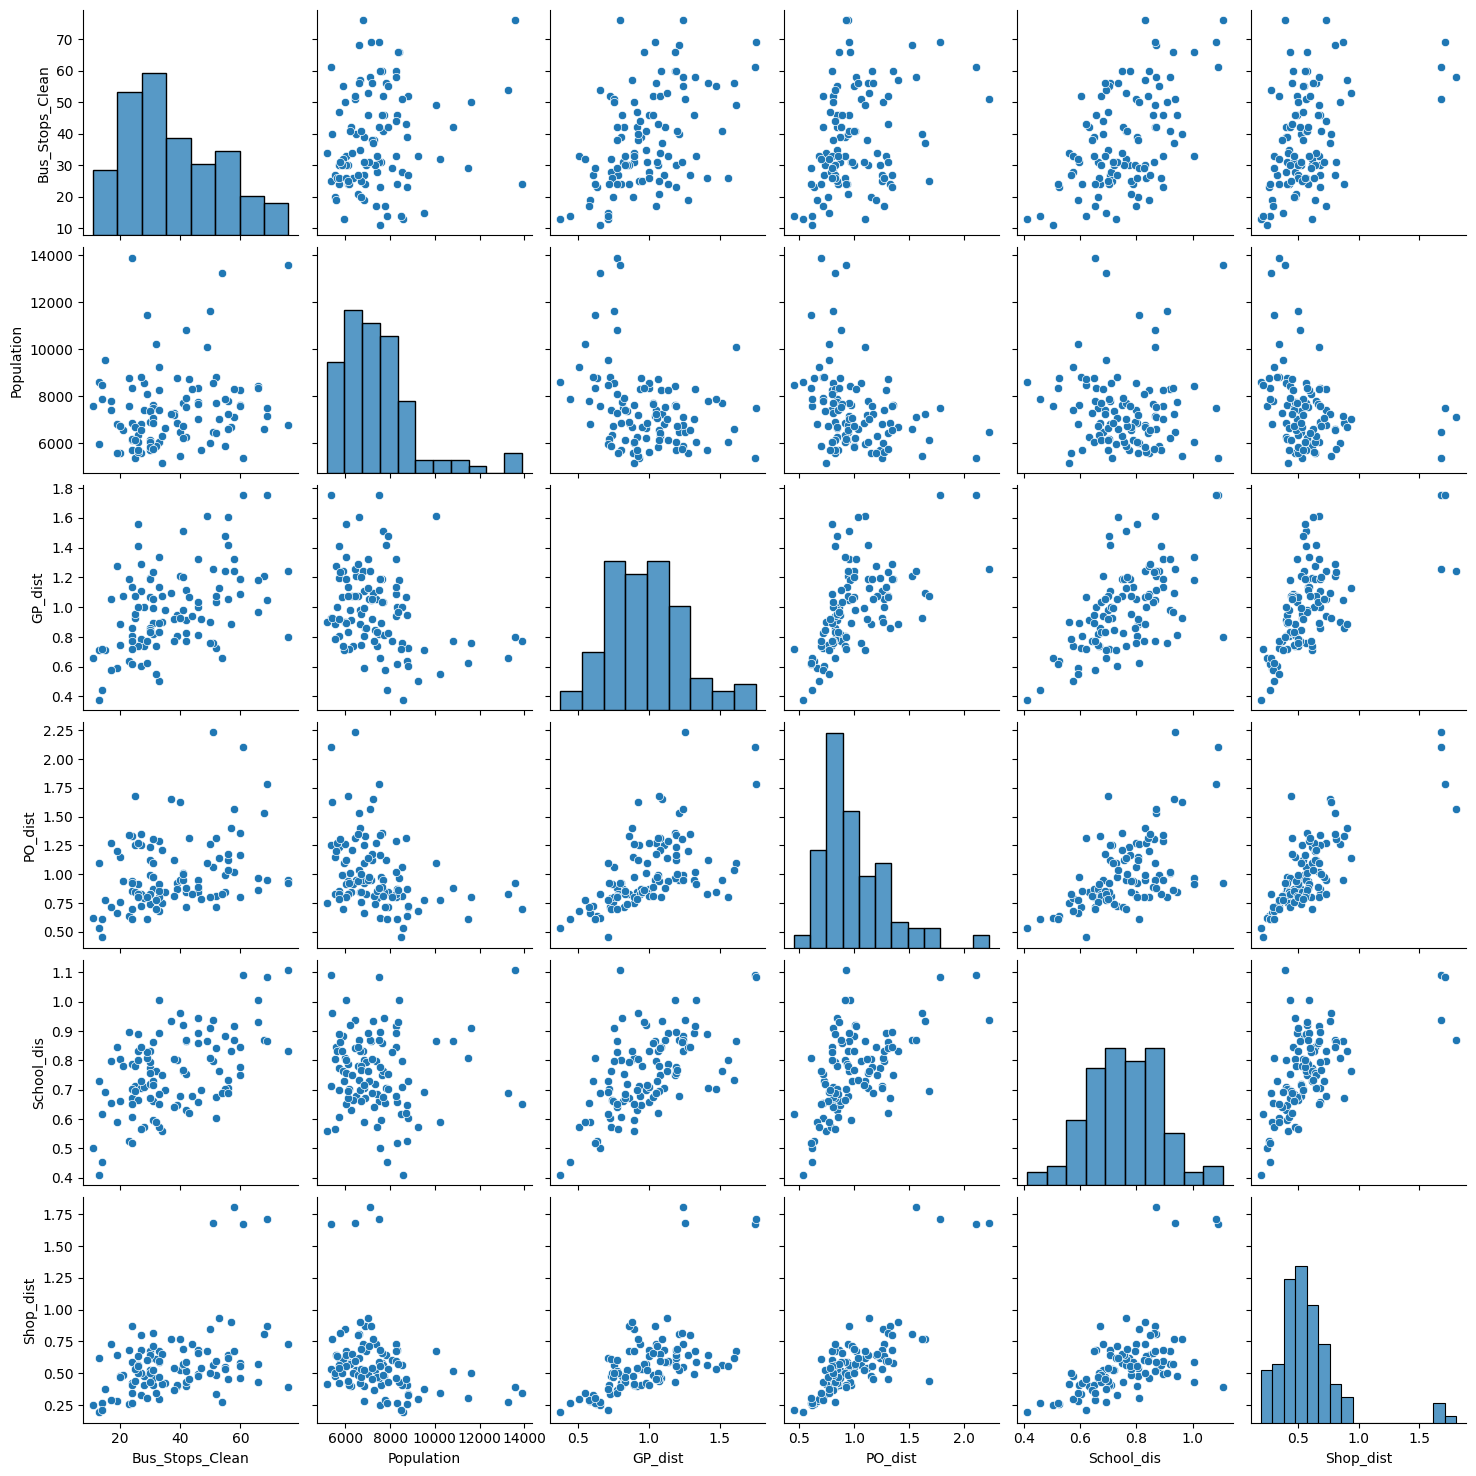

In [35]:
#create a scatter matrix
sns.pairplot(Leeds_sub)

And a correlation heatmap to explore these relationships statistically:

<Axes: >

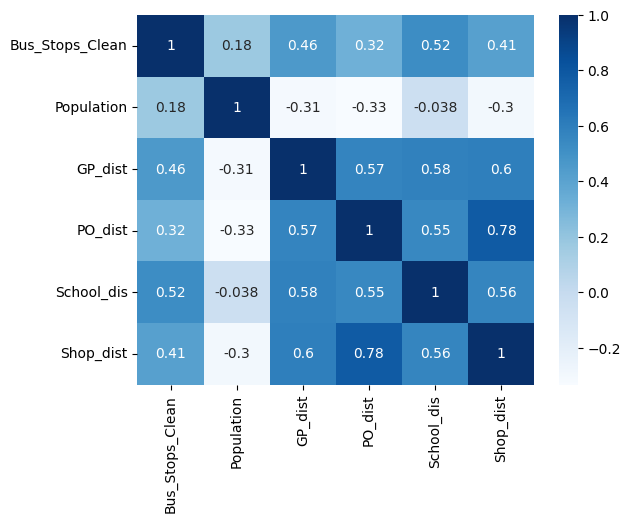

In [36]:
#your heatmap
corr = Leeds_sub.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

What correlations do you observe? Which acessibility measures seem to be most strongly correlated with the number of bus stops?

In [ ]:
#comments here

GP distance and School distance seem to be most strongly correlated with the number of bus stops, indicating that the more bus stops there are, the longer the distance to a GP and school.

We can now build our linear regression model! We'll predict the number of bus stops (our y value, `Bus_Stops_Clean`) from the distance to GPs (our x value). Create your regression model below, and print the results.

In [37]:
y = Leeds_sub['Bus_Stops_Clean']

In [38]:
X = Leeds_sub['GP_dist']

In [39]:
#add the constant
x1 = sm.add_constant(X)

In [40]:
#create the model
mod = sm.OLS(y,x1)

In [41]:
#fit the model
results = mod.fit()

In [42]:
#print the results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Bus_Stops_Clean   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     27.48
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           8.25e-07
Time:                        09:32:39   Log-Likelihood:                -430.96
No. Observations:                 107   AIC:                             865.9
Df Residuals:                     105   BIC:                             871.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7496      4.963      2.569      0.0

What do the results of the model show?

In [43]:
#what do they show?

R-squared of 0.207 suggests a weak positive correlation between the number of bus stops and the distance to a gp. The constant coefficient is the intercept, which says that the estimated GP distance when there are no bus stops is 12.7. The GP_dist coefficient suggests that for each new bus stop, a distance of 25.3 is added to the GP_dist. The Durbin-Watson statistic is 1.891.

We then plot the residuals (errors) to examine whether these are correlated.
If we spot a spatial pattern in our dependent variable or residuals, then we might go on to use GWR. This is because linear regression assumes that our data are all independent, but this assumption is violated if we have spatial relationships in the data. In this case, we'd need to take account of these underlying spatial processes.
Calculate the residuals, and then plot them using LISA, as we did above.

In [44]:
Leeds_bus['LM_res'] = results.resid

In [45]:
#calculate the lisa values
lisa = esda.Moran_Local(Leeds_bus['LM_res'], w_queen)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

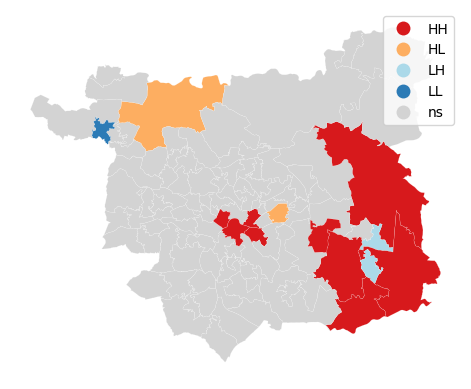

In [46]:
lisa_cluster(lisa, Leeds_bus)

We should observe some significant areas of clustering, which looks similar to our spatial clustering of the number of bus stops, which we saw before. The map should be slightly less colourful, as our linear regression accounts for _some_ of the variation in the data. We can repeat our Moran's _I_ test on the residuals of the linear model, to check the global spatial autocorrelation value.

In [47]:
mi = esda.Moran(Leeds_bus['LM_res'], w_queen)

In [48]:
#print the I valuev
print(mi.I)

0.07645403133602649


In [70]:
#print the significance
print(mi.p_sim)

0.074


The global value has decreased in size and is no longer strongly significant, but if we take a conservative p value cut-off of 0.1- there may be spatial clustering in the data, so we need to use a spatial model (GWR) to capture this variation.

In [49]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

Our _Geographically Weighted Regression_ model essentially calculates a localised model for each point on our map.
The first step is to calculate the optimal bandwidth, which tells our model which areas will be included in each localised regression.

In [50]:
g_coords = list(zip(Leeds_bus.LONG, Leeds_bus.LAT)) #Create a list of x and y coordinates, using the longitude and latitude
g_y = np.asarray(Leeds_bus.Bus_Stops_Clean).reshape((-1,1)) #create our x and y vars, like we do with regression
g_X = np.asarray(Leeds_bus.GP_dist).reshape((-1,1))
gwr_selector = Sel_BW(g_coords, g_y, g_X, fixed = True, spherical = True) #set parameters for calculating the bandwidth

__Note:__ When we `reshape` the X data to an array to create g_x, we use `-1` to flatten the data into the array, followed by `1` because we have one column. If we have more than one column, we'd change the number accordingly. For example, if we had 3 independent variables, the command would be `.reshape(-1,3)`. This may come in useful when you get to the homework questions!

Now we can calculate the optimised _bandwidth_. Remember, the bandwidth is how GWR calculates neighbours within the model.

In [51]:
bw = gwr_selector.search()
print(bw)

25.72


And finally we can put all this information (the co-ordinates, arrays of x and y values, and the bandwidth) into our GWR model!

In [52]:
gwr = GWR(g_coords, g_y, g_X, bw)

Then fit the model, just as we do with linear regression:

In [53]:
gwr_results = gwr.fit()

And view a summary of the results:

In [54]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 107
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          19739.080
Log-likelihood:                                                    -430.964
AIC:                                                                865.928
AICc:                                                               868.161
BIC:                                                              19248.433
R2:                                                                   0.207
Adj. R2:                                                              0.200

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The results table should look pretty familiar, in that the output gives most of the same information as for a linear regression model. The 'Global Regression Results' should be pretty much the same as our OLS results, above. For GWR, we read the results under 'Geographically Weighted Regression Results'. Compare the coefficients (here labelled as X0 and X1 instead of `constant` and `GP_dis`) and the R2 value between both the linear and geographically weighted models- what do you observe?

In [ ]:
#comment on what you observe

You should notice that the values for linear and global models are the same- this is because of the weightings we use in the GWR model allow the coefficients to vary across space, but when they are averaged, the _global_ (overall) values should be the same. To explore this variation, we can plot the local coefficients and examine how they differ across our study area of Leeds.

We can view the parameters, the localised versions of which are returned for each MSOA (the model calculated with the bandwidth around each MSOA). The first column (0- because we index from zero) is the constant, the second (1) is the coefficient of the first variable. If we had more variables, we'd have more columns

In [55]:
#view the parameters
gwr_results.params

array([[-1.05053765e+01,  4.10048121e+01],
       [-6.55129350e+00,  3.89294304e+01],
       [ 6.97492018e-01,  3.28957843e+01],
       [ 2.51605084e+01,  1.15505959e+01],
       [-7.37545879e+00,  3.90022228e+01],
       [-2.30892286e+01,  5.41881886e+01],
       [ 1.42285330e+01,  2.01531092e+01],
       [ 2.79806444e+01,  6.64688606e+00],
       [ 1.35784302e+01,  2.53770258e+01],
       [ 2.92586276e+01,  7.73534429e+00],
       [ 6.21727686e+00,  3.30228126e+01],
       [ 1.23356659e+01,  2.68836678e+01],
       [ 1.11780388e+01,  2.75676834e+01],
       [ 4.65936413e+00,  3.66486350e+01],
       [ 4.84924001e+00,  3.48551357e+01],
       [-1.70057473e+00,  4.25788100e+01],
       [ 2.56781721e+00,  3.86246162e+01],
       [ 9.22354936e+00,  2.97339555e+01],
       [ 8.92238319e+00,  3.09892328e+01],
       [ 5.34631083e+00,  3.24338938e+01],
       [ 1.44684674e+01,  3.04182299e+01],
       [ 1.14305315e+01,  3.20058275e+01],
       [ 6.46365427e+00,  3.97511514e+01],
       [ 5.

We can extract the coefficient of our predictor (X1, aka `GP_dist`), and add it to our `Leeds_bus` dataset.

In [56]:
Leeds_bus['GWR_Beta'] = gwr_results.params[:,1] #keep just the coefficient of our first (only!) predictor variable

We then plot this as a choropleth, using a diverging colour scheme, to examine how the coefficients vary across Leeds.

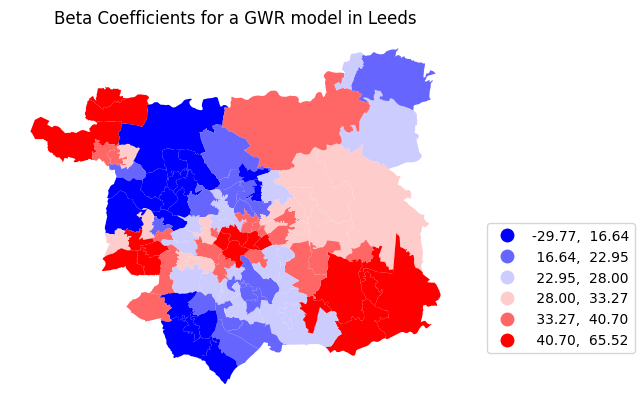

In [57]:
fig, ax = plt.subplots(1)
Leeds_bus.plot(ax = ax,column = 'GWR_Beta', cmap = 'bwr', scheme = 'quantiles', k = 6,legend = True)
plt.title('Beta Coefficients for a GWR model in Leeds') #add a title
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4,0.5))
ax.set_axis_off()
plt.show()

One thing to notice is that, with our diverging colour scheme, the divide between blue and red is at the halfway point of our data. However, as we have positive and negative values, it may be helpful to change our colours so we have blue for negative values, and red for positive. We can do this manually.
We notice that the values fall between -29.77 and 65.52, so we'll divide this into 6 groups:
* -30 to 0
* 0 to 15
* 15 to 25
* 25 to 30
* 30 to 40
* 40 to 66





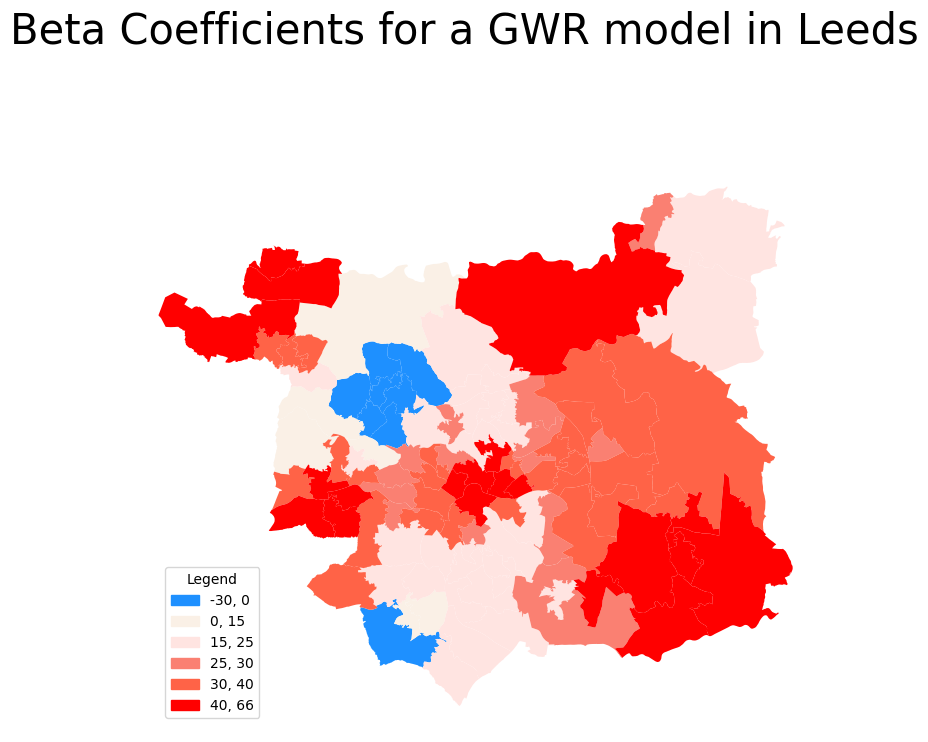

In [58]:
#create a figure
fig, ax = plt.subplots(1, figsize = (9,9))
#plot insignificant clusters
first = Leeds_bus.loc[Leeds_bus['GWR_Beta'] < -0 , 'geometry']
first.plot(ax = ax, color = 'Dodgerblue')
#plot HH clusters
sec = Leeds_bus.loc[(Leeds_bus['GWR_Beta'] < 15) & (Leeds_bus['GWR_Beta'] > 0), 'geometry']
sec.plot(ax=ax, color = 'Linen')
#plot lH clusters
thir = Leeds_bus.loc[(Leeds_bus['GWR_Beta'] < 25) & (Leeds_bus['GWR_Beta'] > 15), 'geometry']
thir.plot(ax=ax, color = 'Mistyrose')
#plot HH clusters
four = Leeds_bus.loc[(Leeds_bus['GWR_Beta'] < 30) & (Leeds_bus['GWR_Beta'] > (25)), 'geometry']
four.plot(ax=ax, color = 'Salmon')
#plot HH clusters
fif = Leeds_bus.loc[(Leeds_bus['GWR_Beta'] < 40) & (Leeds_bus['GWR_Beta'] > 30), 'geometry']
fif.plot(ax=ax, color = 'Tomato')
#plot
six = Leeds_bus.loc[Leeds_bus['GWR_Beta'] > 40 , 'geometry']
six.plot(ax=ax, color = 'Red')
#add titles
fig.suptitle('Beta Coefficients for a GWR model in Leeds', size = 30)
fig.set_facecolor('1')
ax.set_axis_off()

#now add a custom legend, start by creating a coloured and labelled item for each component of the plot
first_lab = mpatches.Patch(color='Dodgerblue', label='-30, 0')
sec_lab = mpatches.Patch(color='Linen', label='0, 15')
thir_lab = mpatches.Patch(color='Mistyrose', label='15, 25')
four_lab = mpatches.Patch(color='Salmon', label='25, 30')
fif_lab = mpatches.Patch(color='Tomato', label='30, 40')
six_lab = mpatches.Patch(color='Red', label='40, 66')

#then plot the legend
leg = plt.legend(handles=[first_lab, sec_lab,thir_lab,four_lab,fif_lab, six_lab], title="Legend")
#and move the legend to a convenient location
leg.set_bbox_to_anchor((0.2,0.3))


plt.show()

These values can be interpreted in the same way as a linear regression coefficient, where the magnitude corresponds to the strength of the association. What do you notice? Where are the stronger positive or negative associations?

In [ ]:
#what pattterns do you observe?

Positive association between number of bus stops and gp distance are clustered in areas like north west, south east, and central, whilst the negative associations are much fewer but clustered in south west and north west. There are only a few clusters of negative associations, where more bus stops corresponds to a smaller distance to a gp, but most regions have a positive association, where more bus stops corresponds to a greater GP distance. The positive associations are stronger than the negative associations.

In the same way as we plotted the residuals above, we can repeat this with the GWR model results, to check whether allowing the parameters to vary spatially has accounted for some of the spatial autocorrelation in the data.

In [59]:
#add the residuals to the Leeds_bus data
Leeds_bus['GWR_res'] = gwr_results.resid_response

In [60]:
#create a LISA cluster map of the new residual variable, using the queen weights
lisa = esda.Moran_Local(Leeds_bus['GWR_res'], w_queen)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

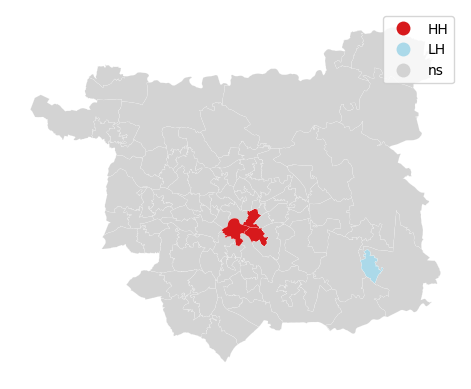

In [61]:
lisa_cluster(lisa, Leeds_bus)

What does this show? A quick reminder of what the legend means:

High-high (dark red): high values surrounded by high values <br>
Low-low (dark blue): low values surrounded by low values <br>
Low-high (light blue): low values surrounded by high values <br>
High-low (yellow): high values surrounded by low values <br>



We should be able to see that most of the residual autocorrelation is gone from the map, meaning that our GWR model has successfully captured a lot of the spatial variation in the data. We can also calculate this at a global level, using the Moran's _I_ value. Calculate this below:

In [63]:
#calculate Moran's I
mi = esda.Moran(Leeds_bus['GWR_res'], w_queen)

In [64]:
#find the I value
print(mi.I)

-0.09105394954260602


In [65]:
#find the significance
print(mi.p_sim)

0.079


We can see from the LISA plot that the amount of clustering has decreased, and the significance is further reduced.
To improve this further, we could try adding further predictor variables- but we'll save this for an extension task!

<br><br><br>
## Multilevel Models

And finally, we come to multilevel models, where we allow our parameters to vary at different levels of the data. For this, we'll look at the associations at the MSOA level (like in our linear regression model), but also model the variation across different areas of the city, using our `Location` variable.

Create a map of the MSOAs, colouring according to the `Location` column. Remember to add a legend and move it off the map.

In [77]:
Leeds_bus.head()

,OBJECTID,MSOA11CD,MSOA11NM,LONG,LAT,Location,outline,Area,GP_dist,PO_dist,...,Population,Bus_Stops,geometry,W_Q_Score,Bus_Stops_Clean,Sig,Quad,LM_res,GWR_Beta,GWR_res
0,1716,E02002337,Leeds 008,-1.752,53.880,North,1,1.488289e+07,1.053273,1.268455,...,7388,17,"POLYGON ((418310.512 440995.504, 418283.825 44...",45.0,17,False,2,-22.453547,41.004812,-15.683885
1,1718,E02002339,Leeds 010,-1.692,53.868,North,1,1.413270e+06,0.928857,1.253929,...,5351,25,"POLYGON ((420442.406 442436.687, 420443.313 44...",32.4,25,False,3,-11.299186,38.929430,-4.608580
2,1719,E02002340,Leeds 011,-1.678,53.868,North,1,2.175963e+06,0.888700,1.152800,...,5554,20,"POLYGON ((421248.688 442315.812, 421284.072 44...",41.0,20,False,2,-15.281072,32.895784,-9.931976
3,2527,E02002336,Leeds 007,-1.639,53.883,North,1,2.879803e+07,1.211063,1.528187,...,6596,68,"POLYGON ((422959.334 445561.228, 422975.661 44...",33.3,68,False,4,24.545951,11.550596,28.850992
4,1717,E02002338,Leeds 009,-1.709,53.870,North,1,2.126169e+06,1.106091,1.255364,...,6817,27,"POLYGON ((419597.106 440500.097, 419562.826 44...",24.0,27,True,3,-13.792659,39.002223,-8.764549


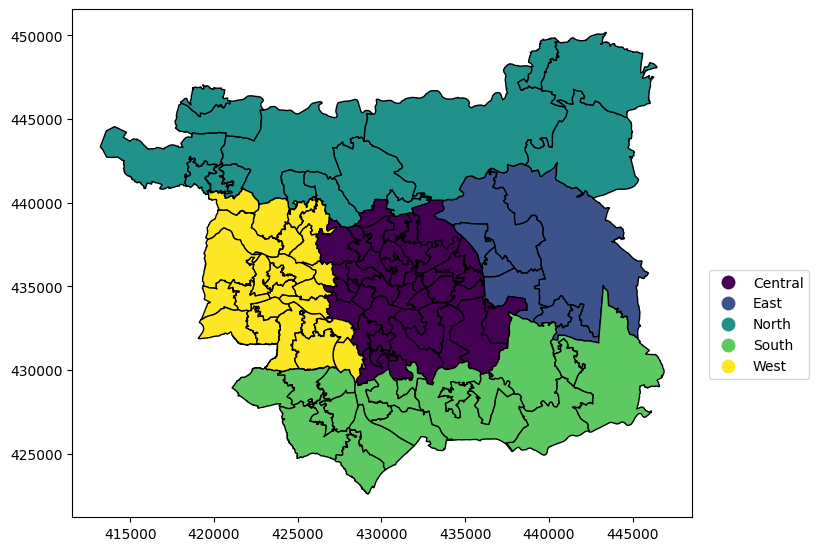

In [76]:
#map highlighting the different areas of Leeds
fig, ax = plt.subplots(1,1,figsize=(8,8))
Leeds_bus.plot(column='Location', cmap='viridis',legend=True, ax=ax, edgecolor='black')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.2,0.5))
plt.show()

We'll still focus on the number of bus stops, so we examine how these vary by Location, through a violin plot with quartiles:

<Axes: xlabel='Location', ylabel='Bus_Stops'>

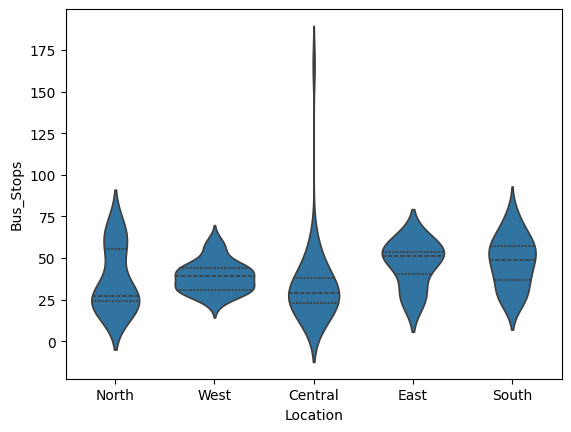

In [79]:
#create a violin plot of the number of bus stops by area
sns.violinplot(x='Location', y='Bus_Stops', data=Leeds_bus, inner='quartile')

We can see some very different distributions, so this gives us a case for examining the variation in each of these areas.

As we did with GWR, we first build our linear regression model, so we can compare the results. As we've already done this, we can just print the results summary again:

In [80]:
#print the results summary of the linear regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Bus_Stops_Clean   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     27.48
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           8.25e-07
Time:                        10:45:29   Log-Likelihood:                -430.96
No. Observations:                 107   AIC:                             865.9
Df Residuals:                     105   BIC:                             871.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7496      4.963      2.569      0.0

So we now build our multilevel model, which, somewhat annoyingly, uses a different method. If you're familiar with R, this is a similar method. We essentially write the equation we want to use. The model is the same linear model but we'll add `Location` as our grouping variable, telling Python to consider variation across both the MSOAs (where we measure bus stops and school access) and the city Locations. This model will include _random intercepts_ (each group has a different intercept) and _random coeffcients_ (each group has a different regression coefficient). Essentially, this creates a different regression for each group (location).

In [81]:
import statsmodels.formula.api as smf

In [82]:
mlm_results = smf.mixedlm("Bus_Stops_Clean ~ School_dis", Leeds_bus, groups= "Location").fit()

__Note:__ The format of the regression is `y ~ x`. If you want to add more variables to the model, you should use the format `y ~ x1 + x2 + x3`.

And examine our results summary (we should be getting the hang of this by now).

In [83]:
mlm_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Bus_Stops_Clean
No. Observations: 107     Method:             REML           
No. Groups:       5       Scale:              159.0998       
Min. group size:  7       Log-Likelihood:     -419.9526      
Max. group size:  41      Converged:          Yes            
Mean group size:  21.4                                       
--------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------
Intercept     -4.027     8.025  -0.502  0.616  -19.755  11.701
School_dis    56.213     9.892   5.683  0.000   36.826  75.601
Location Var  17.714     1.493                                
=============================================================

"""

This output looks a little different in format, but still contains the same information as our previous regression models, with a few extras.

There are a few other things to note:

1) Our coefficients for our intercept and school access should be similar, though not exactly the same, as our first model. These are the averages, although we can find the variation for each group (location).

2) There is significant variation at the area level (we will examine how this varies across areas in a second). This is indicated by the 'Location Var' output, which means the 'Location Variance'. Here, the value of the variance is 17.714, which means that we see a variation of over 17 in the number of bus stops across the different locations in the city.

3) We can look at the log-likelihood statistic of each model to find the best fit, which we introduced in the lecture. You can read up more on log-likelihood [here](https://www.statology.org/interpret-log-likelihood/), but essentially it's another measure of fit, like the R2 value, where a higher number indicates a better fit.

4) Multi-level models are not really Python's forte, so we'll pretty much leave it here for now!


One last thing before we wrap up (phew!), we can examine the association between each area and the number of bus stops. We can look at the coefficients of the random (area-level) effects, and also plot them.

We print the random (area-level) effects:

In [84]:
print(mlm_results.random_effects)

{'Central': Location   -3.761736
dtype: float64, 'East': Location    1.851899
dtype: float64, 'North': Location   -3.467308
dtype: float64, 'South': Location    3.575065
dtype: float64, 'West': Location    1.80208
dtype: float64}


We can create a scatter plot to visualise the differences between the groups. We'll start with plotting the random effects, so we need to make a data frame first:

In [85]:
mlm_random_effects = pd.DataFrame.from_dict(mlm_results.random_effects, orient='index') #create a data frame
mlm_random_effects = mlm_random_effects.rename({'Location': 'Random Effects'}, axis=1) #change the column name
mlm_random_effects['Location'] = ['Central', 'East', 'North', 'South', 'West'] #add the locations
mlm_random_effects #view the dataframe

,Random Effects,Location
Central,-3.761736,Central
East,1.851899,East
North,-3.467308,North
South,3.575065,South
West,1.802080,West


Now we can create our scatter plot, increasing the size of the markers, and colouring these according to the location.

<Figure size 640x480 with 0 Axes>

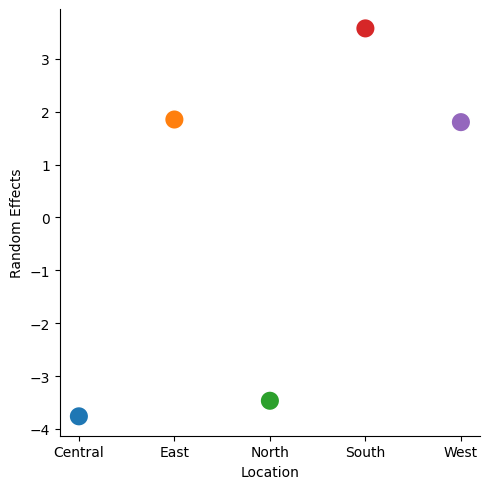

In [86]:
fig = plt.figure()
sns.relplot(data = mlm_random_effects, x = 'Location', y = 'Random Effects', hue = 'Location', marker = 'o', s = 200, legend = False)

plt.show()

And, finally (!) we can create a boxplot of the residuals, to observe how the model performs in each area:

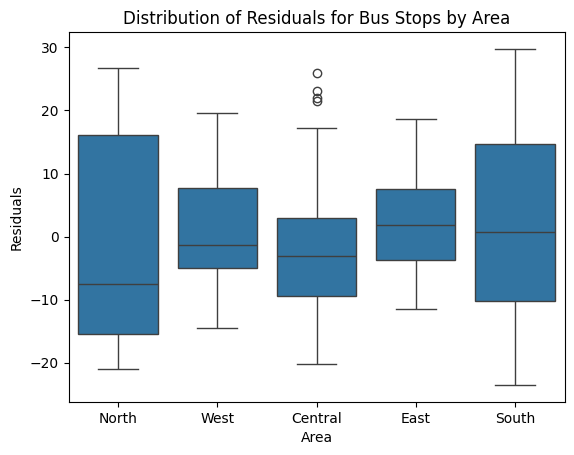

In [87]:
fig = plt.figure()

ax = sns.boxplot(x = mlm_results.model.groups, y = mlm_results.resid)

ax.set_title("Distribution of Residuals for Bus Stops by Area")
ax.set_ylabel("Residuals")
ax.set_xlabel("Area")
plt.show()

<br><br><br>
## Formative Homework Questions
<br>

Now it's your turn to try out GWR and Multilevel Models, to predict number of Bus Stops. Use distance to schools, shops, post offices, and GP surgeries, as well as population, as your predictors.

__Question 1:__ Create a GWR model, and plot a LISA map of the residuals from the model. What is the R2 value?

__Question 2:__ Create a MLM model, and create a box plot of the residuals. What is the variance of the location variable?

Once you've completed these exercises, submit your answers via Minerva, as usual

# Question 1 - GWR model

In [88]:
Leeds_sub = Leeds_bus[['Bus_Stops_Clean', 'Population', 'GP_dist', 'PO_dist', 'School_dis', 'Shop_dist']]

In [92]:
g_coords = list(zip(Leeds_bus.LONG, Leeds_bus.LAT)) #Create a list of x and y coordinates, using the longitude and latitude
g_y = np.asarray(Leeds_bus.Bus_Stops_Clean).reshape((-1,1)) #create our x and y vars, like we do with regression
g_X = np.column_stack((Leeds_bus.GP_dist, Leeds_bus.PO_dist, Leeds_bus.School_dis, Leeds_bus.Shop_dist, Leeds_bus.Population)).reshape((-1,5))
gwr_selector = Sel_BW(g_coords, g_y, g_X, fixed = True, spherical = True) #set parameters for calculating the bandwidth

In [93]:
bw = gwr_selector.search()
print(bw)

59.02


In [94]:
gwr = GWR(g_coords, g_y, g_X, bw)

In [95]:
gwr_results = gwr.fit()

In [96]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 107
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          14730.865
Log-likelihood:                                                    -415.307
AIC:                                                                842.614
AICc:                                                               845.745
BIC:                                                              14258.909
R2:                                                                   0.409
Adj. R2:                                                              0.379

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [97]:
#add the residuals to the Leeds_bus data
Leeds_bus['GWR_res'] = gwr_results.resid_response

In [98]:
#create a LISA cluster map of the new residual variable, using the queen weights
lisa = esda.Moran_Local(Leeds_bus['GWR_res'], w_queen)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

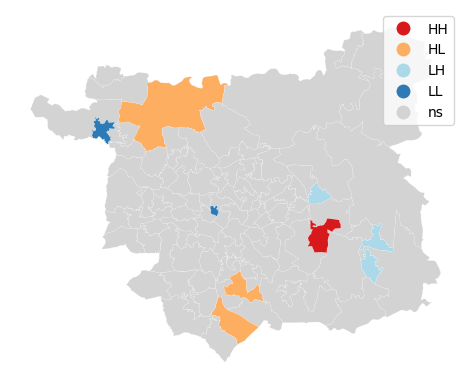

In [99]:
lisa_cluster(lisa, Leeds_bus)

# Question 2

In [100]:
mlm_results = smf.mixedlm("Bus_Stops_Clean ~ School_dis + GP_dist + PO_dist + Shop_dist + Population",
                          Leeds_bus, groups= "Location").fit()

In [101]:
mlm_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Bus_Stops_Clean
No. Observations: 107     Method:             REML           
No. Groups:       5       Scale:              134.1950       
Min. group size:  7       Log-Likelihood:     -407.3490      
Max. group size:  41      Converged:          Yes            
Mean group size:  21.4                                       
-------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------
Intercept        -28.349    9.904 -2.862 0.004 -47.760 -8.937
School_dis        30.935   11.809  2.620 0.009   7.789 54.080
GP_dist           11.178    6.570  1.701 0.089  -1.699 24.054
PO_dist           -0.191    6.877 -0.028 0.978 -13.670 13.288
Shop_dist         13.784    7.059  1.953 0.051  -0.051 27.618
Population         0.003    0.001  4.244 0.000   0.002  0.005
Location Var      18.073    1.655                            
=============================================================

"""

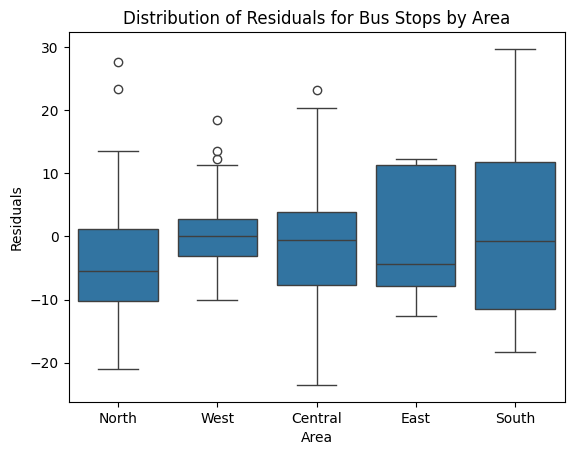

In [102]:
fig = plt.figure()

ax = sns.boxplot(x = mlm_results.model.groups, y = mlm_results.resid)

ax.set_title("Distribution of Residuals for Bus Stops by Area")
ax.set_ylabel("Residuals")
ax.set_xlabel("Area")
plt.show()